In [1]:
import logging
logger = logging.getLogger()
for handler in logger.handlers:
    handler.level = logging.WARNING
handler = logging.FileHandler(filename='crime.log', mode='w')
handler.level = logging.DEBUG
logger.level = logging.DEBUG
logger.addHandler(handler)

In [2]:
%matplotlib inline
from autograd import numpy as np
import autograd
import bayesian_pdes as bpdes
import sympy as sp
import matplotlib.pyplot as plt
import sympy_rbf as rbf

In [3]:
omega = 1./15
eta = 0.03
Theta = 0.056
Gamma = 0.19
A_0 = 1./300
l = 1.
dt = 0.05
D = l**2 / (2*dt)

In [4]:
x, y = sp.symbols('x,y')
t, tbar = sp.symbols('t,tbar')

def op_A(k):
    return k.diff(t) - eta*D*k.diff(x, x) + omega*(k - A_0)
def op_A_bar(k):
    return k.diff(tbar) - eta*D*k.diff(y, y) + omega*(k - A_0)

#also want first and second derivs wrt x, y
def A_x(k): return k.diff(x)
def A_xx(k): return k.diff(x, x)
def A_y(k): return k.diff(y)
def A_yy(k): return k.diff(y,y)

sA, sA_x, sA_xx = sp.symbols('A,A_x, A_xx')
sA_bar, sA_x_bar, sA_xx_bar = sp.symbols('A_bar, A_x_bar, A_xx_bar')

def op_rho(k):
    return k.diff(t) - D * (k.diff(x, x) - 2*k.diff(x) * sA_x/sA - 2*k*(sA_xx/sA - (sA_x/sA)**2)) + k*sA - eta

def op_rho_bar(k):
    return k.diff(tbar) \
        - D * ( \
                k.diff(y, y) - 2*k.diff(y) * sA_x_bar/sA_bar - 2*k*(sA_xx_bar/sA_bar - (sA_x_bar/sA_bar)**2) \
              ) + k*sA_bar - eta

ls_x, ls_t = sp.symbols('ls_x, ls_t')
k = sp.exp(-(x-y)**2 / (2*ls_x**2))*(sp.exp(-(t-tbar)**2 / (2*ls_t**2)))
periodic_spatial = rbf.PeriodicKern.create([x], [y], ls_x, 1.0)
k_per = periodic_spatial * sp.exp(-(t-tbar)**2 / (2*ls_t**2))


kern = k

In [5]:
op_system_A = bpdes.operator_compilation.compile_sympy(
    [op_A, A_x, A_xx], 
    [op_A_bar, A_y, A_yy], 
    kern, 
    [[x, t], [y, tbar], [ls_x, ls_t]], 
    mode='cython',
    sympy_function_kwargs={
        'compile_helpers': [periodic_spatial.get_helper()]
    }
)

In [6]:
op_system_rho = bpdes.operator_compilation.compile_sympy(
    [op_rho],
    [op_rho_bar],
    kern,
    [[x, t, sA, sA_x, sA_xx], [y, tbar, sA_bar, sA_x_bar, sA_xx_bar], [ls_x, ls_t]],
    mode='cython',
    sympy_function_kwargs={
        'compile_helpers': [periodic_spatial.get_helper()]
    }
)

In [7]:
fun_args = np.array([0.1, 0.1])

In [8]:
times = np.arange(0,2,dt)
design_points = np.linspace(0,1,11)[:,None]
test_points = np.linspace(0,1,51)[:,None]

def obs_function(t):
    design = bpdes.parabolic.augment_with_time(design_points, t)
    values = np.zeros((design.shape[0], 1))
    return [(design, values)]

def test_function(t):
    return bpdes.parabolic.augment_with_time(test_points, t)

A_t0 = A_0 + Theta*D*eta/omega

initial_points = bpdes.parabolic.augment_with_time(design_points, 0)
init_A = A_t0 * np.ones((initial_points.shape[0], 1))

ics = [(initial_points, init_A)]

posteriors = bpdes.parabolic.solve_parabolic(op_system_A, [op_A], [op_A_bar], times, obs_function, ics, fun_args)

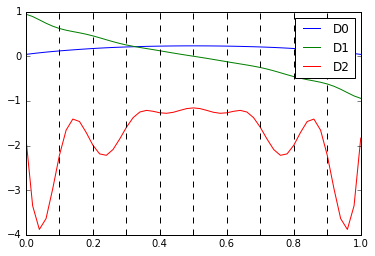

In [9]:
p_ix = 4
p = posteriors[p_ix]
pts = test_function(times[p_ix])
mu, cov = p.apply_operator([(), A_x, A_xx], [(), A_y, A_yy])(pts)
for i in range(3):
    plt.plot(pts[:,0], mu[i*len(pts):(i+1)*len(pts)], label='D{}'.format(i))
for item in design_points:
    plt.axvline(item, linestyle='--', c='black')
plt.legend()

In [10]:
mu = []
cov = []
for t, posterior in zip(times, posteriors):
    test_t = test_function(t)
    mu_t, cov_t = posterior(test_t)
    mu.append(mu_t)

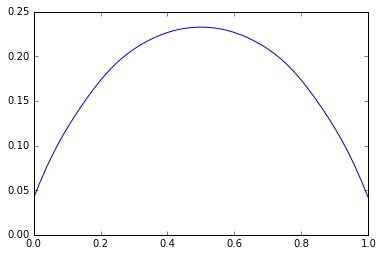

In [11]:
plt.plot(test_points, mu[4]);

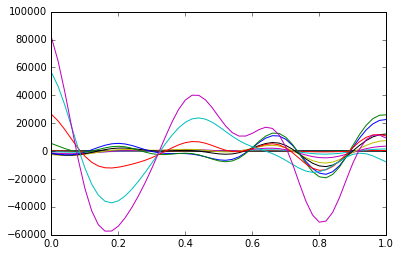

In [12]:
plt.plot(test_points, np.column_stack(mu));

# Now rho

In [13]:
Identity = ()
def make_rho_locs(t, A, A_x, A_xx):
    locs = bpdes.parabolic.augment_with_time(design_points, t)
    locs = np.column_stack([locs, A, A_x, A_xx])
    return locs
def make_rho_obs(t, A, A_x, A_xx):
    locations = make_rho_locs(t, A, A_x, A_xx)
    return [(locations, np.zeros((locations.shape[0], 1)))]

rho_t0 = 1./l**2
rho_loc_0 = make_rho_locs(times[0], init_A, np.zeros_like(init_A), np.zeros_like(init_A))
init_rho = rho_t0*np.ones((rho_loc_0.shape[0], 1))
rho_obs_0 = [(rho_loc_0, init_rho)]
rho_posterior_t0 = bpdes.collocation.collocate([Identity], [Identity], rho_obs_0, op_system_rho, fun_args)

In [14]:
A_posterior_t1 = posteriors[1].apply_operator([Identity, A_x, A_xx], [Identity, A_y, A_yy])
samp = A_posterior_t1.sample(obs_function(times[1])[0][0]).T
A_samp, A_x_samp, A_xx_samp = samp[:len(samp)/3], samp[len(samp)/3:2*len(samp)/3], samp[2*len(samp)/3:]

In [15]:
all_rho_ops = [[Identity], [op_rho]] + [[op_rho]]
all_rho_ops_bar = [[Identity], [op_rho_bar]]
all_rho_obs = [rho_obs_0, make_rho_obs(times[1], A_samp, A_x_samp, A_xx_samp)]
rho_posterior_t1 = bpdes.parabolic.step_forward(all_rho_ops, all_rho_ops_bar, all_rho_obs, op_system_rho, fun_args, rho_posterior_t0)

In [16]:
rho_posterior_t1

# try autograd

In [ ]:
from bayesian_pdes.operator_compilation.autograd import AutogradOperatorSystem

In [ ]:
def sqexp(x,t,y,tbar,args):
    return np.exp(-((x-y)*(x-y)) / (2*args[0]**2)) * np.exp(-(t-tbar)*(t-tbar) / (2*args[1]**2))

In [ ]:
def op_A(k):
    grad_k_x = autograd.grad(k)
    grad_k_xx = autograd.grad(grad_k_x)
    grad_k_t = autograd.grad(k,1)
    
    def __ret__(x, t, y, tbar, args):
        return grad_k_t(x, t, y, tbar, args) - eta*D*grad_k_xx(x, t, y, tbar, args) + omega*(k(x,t,y,tbar,args) - A_0)
    return __ret__
def op_A_bar(k):
    grad_k_x = autograd.grad(k,2)
    grad_k_xx = autograd.grad(grad_k_x,2)
    grad_k_t = autograd.grad(k,3)
    
    def __ret__(x, t, y, tbar, args):
        return grad_k_t(x, t, y, tbar, args) - eta*D*grad_k_xx(x, t, y, tbar, args) + omega*(k(x,t,y,tbar,args) - A_0)
    return __ret__

In [ ]:
def wrapper(fun):
    def __ret__(x, y, args):
        t = x[1]
        tbar = y[1]
        x = x[0]
        y = y[0]
        return fun(x, t, y, tbar, args)
    
    return __ret__

In [ ]:
op_system = AutogradOperatorSystem([op_A], [op_A_bar], sqexp, wrapper)

In [ ]:
times = np.arange(0, 1, dt)[1:]
space_points = np.linspace(0,1,11)[:,None]

t = times[0]*np.ones_like(space_points)

design_points = np.column_stack([space_points, t])

In [ ]:
LLbar = op_system[(op_A, op_A_bar)]
llbar = LLbar(design_points, design_points, np.array([0.5, 0.5]))
llbar_inv = np.linalg.inv(llbar)

In [ ]:
def new_kern(x, t, y, tbar, args):
    left_arr = []
    right_arr = []
    left = op_system.get_raw((op_A_bar,))
    right = op_system.get_raw((op_A,))
    for i in range(design_points.shape[0]):
        left_arr.append(left(x, t, design_points[i, 0], design_points[i, 1], args))
        right_arr.append(right(design_points[i, 0], design_points[i, 1], y, tbar, args))
    left = np.array([left_arr])
    right = np.array([right_arr])
    kern = op_system.get_raw(())(x, t, y, tbar, args)
    return kern - np.dot(np.dot(left, llbar_inv), right.T)

In [ ]:
new_op_system = AutogradOperatorSystem([op_A], [op_A_bar], new_kern, wrapper)

In [ ]:
t2 = times[1]*np.ones_like(space_points)

design_points_2 = np.column_stack([space_points, t2])

In [ ]:
test = op_system.get_raw((op_A, op_A_bar))
test_new = new_op_system.get_raw((op_A, op_A_bar))

In [ ]:
%%timeit
test(design_points_2[0,0], design_points_2[0,1], design_points_2[0,0], design_points_2[0,1], np.array([0.5, 0.5]))

In [ ]:
%lprun -f new_kern test_new(design_points_2[0,0], design_points_2[0,1], design_points_2[0,0], design_points_2[0,1], np.array([0.5, 0.5]))

In [ ]:
LLbar = new_op_system[(op_A, op_A_bar)]
llbar_2 = LLbar(design_points_2, design_points_2, np.array([0.5, 0.5]))
llbar_inv_2 = np.linalg.inv(llbar_2)

In [ ]:
llbar_2

In [ ]:
import theano as th
import theano.tensor as tt

In [ ]:
x_vec, y_vec = tt.dvectors(['x', 'y'])
sigma = tt.scalar('sigma')
gaussian_kernel = tt.exp(-tt.sum(tt.square(x_vec - y_vec)) / (2*sigma**2))

def divergence(f, wrt):
    grad2, _ = th.scan(fn=lambda i, x, f: tt.grad(f[i], x)[i], sequences=tt.arange(wrt.shape[0]), non_sequences=[wrt, f])
    return tt.sum(grad2)

def laplacian(f, wrt):
    return tt.sum(tt.diagonal(tt.hessian(f, wrt)))

def A(k):
    return laplacian(k, x_vec)

def A_bar(k):
    return laplacian(k, y_vec)

def B(k):
    return k

B_bar = B

def calc_kernel(x, y, old_kernel, ops, ops_bar, obs):
    llbar = build_llbar(old_kernel, ops, ops_bar, obs)
    l, lbar = calc_side_matrices(old_kernel, ops, ops_bar, obs, x, y)
    llbar_inv = tt.inv(llbar)
    
    return old_kernel - tt.dot(lbar, tt.dot(llbar_inv, l))

def build_llbar(kern, ops, ops_bar, obs):
    row_list = []
    for op, pt in zip(ops, obs):
        col_list = []
        for op_bar, pt_bar in zip(ops_bar, obs):
            applied = op_bar(op(kern))
            diffed_kern = gram_matrix(pt, pt_bar, applied)
            col_list.append(diffed_kern)
        row_list.append(tt.concatenate(col_list, axis=1))
    return tt.concatenate(row_list)

def calc_side_matrices(kern, ops, ops_bar, obs, X, Y):
    L = []
    Lbar = []
    for op, op_bar, point in zip(ops, ops_bar, obs):
        # this actually just needs to be *half* a gram_matrix
        f = tt.transpose(half_gram_matrix(Y, point, op(kern)))
        fbar = half_gram_matrix(X, point, op_bar(kern))
        L.append(f)
        Lbar.append(fbar)
    L = tt.concatenate(L)
    Lbar = tt.concatenate(Lbar, axis=1)
    return L, Lbar
    
def half_gram_matrix(x, Y, kernel):
    N = Y.shape[0]
    
    def kernel_subs(y_replace):
        return th.clone(kernel, {y_vec:y_replace})
    
    R, _ = th.scan(
        fn=lambda k: kernel_subs(Y[k % N]),
        sequences=[tt.arange(N)])
    
    return R.reshape([1, N])
                        
def gram_matrix(X, Y, kernel):
    M = X.shape[0]
    N = Y.shape[0]
    
    def kernel_subs(x_replace, y_replace):
        return th.clone(kernel, {x_vec:x_replace, y_vec:y_replace})
    
    R, _ = th.scan(
        fn=lambda k: kernel_subs(X[k // N], Y[k % N]),
        sequences=[tt.arange(M * N)])

    return R.reshape([M, N])

X = tt.dmatrix('X')
Y = tt.dmatrix('Y')
K = gram_matrix(X, Y, gaussian_kernel)

f = th.function([X, Y, sigma], [K])

In [ ]:
tmp = laplacian(gaussian_kernel, x_vec)

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f tt.hessian laplacian(tmp, y_vec)

In [ ]:
x,y = sp.symbols('x,y')
k_sp = sp.exp(-(x-y)**2 / (2*0.1**2))
A_sp = lambda k: k.diff(x,x)
A_bar_sp = lambda k: k.diff(y,y)
B_sp = lambda k: k
B_bar_sp = B_sp
oc = bpdes.operator_compilation.compile_sympy([A_sp, B_sp], [A_bar_sp, B_bar_sp], k_sp, [[x], [y]], mode='cython')

In [ ]:
sympy_llbar = bpdes.collocation.calc_LLbar([A_sp, B_sp], [A_bar_sp, B_bar_sp], [(interior, None), (bdy,None)], oc)

In [ ]:
obs_A = tt.dmatrix('O_A')
obs_B = tt.dmatrix('O_B')
new_kernel = calc_kernel(x_vec, y_vec, gaussian_kernel, [A, B], [A_bar, B_bar], [obs_A, obs_B])

In [ ]:
llbar_fun = th.function([obs_A, obs_B, sigma], build_llbar(gaussian_kernel, [A, B], [A_bar, B_bar], [obs_A, obs_B]))

In [ ]:
import numpy.testing

In [ ]:
gm = gram_matrix(X, Y, new_kernel)

In [ ]:
f = th.function([X, Y, obs_A, obs_B, sigma], [gm])

In [ ]:
f(test, test, interior, bdy, 0.1)

In [ ]:
test = np.linspace(0,1,101)[:,None]
design = np.linspace(0,1,11)[:,None]
interior = design[1:-1]
bdy = design[[0,-1]]
cov = f(test,test, interior, bdy)

In [ ]:
plt.matshow(cov[0]); plt.colorbar()

In [ ]:
gm = gram_matrix(X, Y, lambda X, Y: tt.jacobian(gaussian_kernel(X, Y), X))

In [ ]:
f = th.function([X, Y], [gm])

In [ ]:
f(x,x)

In [ ]:
x = np.random.normal(size=(100,1))

In [ ]:
f(x,x)